In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import scipy as sp
from scipy import stats
import pickle

import pymc3 as pm
from pymc3.ode import DifferentialEquation
import arviz as az
from theano import tensor as tt
from tqdm.notebook import tqdm

from Utils import myUtils as mypy
from Analysis import processQuantStudio as pQS
from Analysis import PYMCutils as pmu

%config InlineBackend.figure_format ='retina'
%config Completer.use_jedi = False
%load_ext Utils.skip_kernel_ext
%load_ext autoreload
%aimport Utils
%aimport Analysis
#%aimport pcr
#pd.options.mode.chained_assignment = None  # default='warn'

In [2]:
code_pth, base_pth, data_pth, rslt_pth, fig_pth = mypy.setupPath()
plt.style.use(str(code_pth / 'Utils' / 'futura_presentation.mplstyle'))

def savemyfig(fig,name,path=fig_pth):
    mypy.savemyfig(fig,'JG047 '+name,path)
    
savefigs = False

In [3]:
# import warnings filter
from warnings import simplefilter
# ignore all future warnings
simplefilter(action='ignore', category=FutureWarning)

In [4]:
SEED=2020

# Load in TMCC1 Data

In [5]:
import importlib as il

In [22]:
il.reload(pQS)

<module 'Analysis.processQuantStudio' from '/rds/general/user/jgoertz/home/JG047/Code/Analysis/processQuantStudio.py'>

In [7]:
gen12_imp = pQS.importQuantStudio(data_pth, 'JG034 TMCC1 Gen 2 Competitors Solo - 59C.xlsx')
gen3_imp = pQS.importQuantStudio(data_pth, 'JG047A TMCC1 Gen3 - Probe.xlsx')

In [8]:
gen12_aliases =   {
    'WT' : 'BP88_GC43_WT', 'ISO' : 'BP88_GC43_ISO',
    'BP15' : 'BP15_GC43', 'BP30' : 'BP30_GC43', 'BP40' : 'BP40_GC43', 'BP55' : 'BP55_GC43', 'BP160' : 'BP160_GC43', 'BP200' : 'BP200_GC43', 'BP240' : 'BP240_GC43',
    'GC15' : 'BP88_GC15', 'GC25' : 'BP88_GC25', 'GC35' : 'BP88_GC35', 'GC55' : 'BP88_GC55', 'GC65' : 'BP88_GC65', 'GC75' : 'BP88_GC75', 'GC80' : 'BP88_GC80', 'GC85' : 'BP88_GC85',
}

gen12_rxns = pQS.formatSNXimport(gen12_imp).assign(Batch=1).replace(gen12_aliases)
gen12_rxns = pQS.apply_reaction_bounds(gen12_rxns)
gen12_rxns = pQS.trim_reactions(gen12_rxns)

gen3_rxns = pQS.formatSNXimport(gen3_imp).assign(Batch=2)
gen3_rxns = pQS.apply_reaction_bounds(gen3_rxns)
gen3_rxns[gen3_rxns.Tar=="BP160_GC80"] = pQS.apply_reaction_bounds(gen3_rxns.query('Tar=="BP160_GC80"'), threshold=0.001)
gen3_rxns = pQS.trim_reactions(gen3_rxns)

imp = {sheet:pd.concat([gen12_imp[sheet],gen3_imp[sheet].assign(Batch=2)]) for sheet in gen12_imp}

tmcc1_rxns = rxns = pd.concat([gen12_rxns,gen3_rxns]).reset_index(drop=True)
rxns.to_pickle(data_pth / 'TMCC1_rxns.pkl',protocol=4)

outliers = rxns.outlier

In [9]:
t_list = [
    'BP500_GC40','BP500_GC60' ,     'BP280_GC30', 'BP280_GC70' ,
    'BP240_GC43',
    'BP200_GC43',
    'BP160_GC10', 'BP160_GC20' , 'BP160_GC43' , 'BP160_GC60' , 'BP160_GC80' ,
    'BP88_GC15' , 'BP88_GC25' , 'BP88_GC35' , 'BP88_GC43_ISO', 'BP88_GC43_WT', 'BP88_GC55' , 'BP88_GC65' , 'BP88_GC75' , 'BP88_GC80' , 'BP88_GC85' ,
    'BP55_GC43' ,
    'BP50_GC25' , 'BP50_GC60' , 'BP50_GC75' ,
    'BP40_GC43' ,
    'BP30_GC43' ,
    'NTC' , 'legend' ,
]

tmcc1_targets = rxns.query('Tar!="NTC"').Tar.unique()
n_t = len(tmcc1_targets)

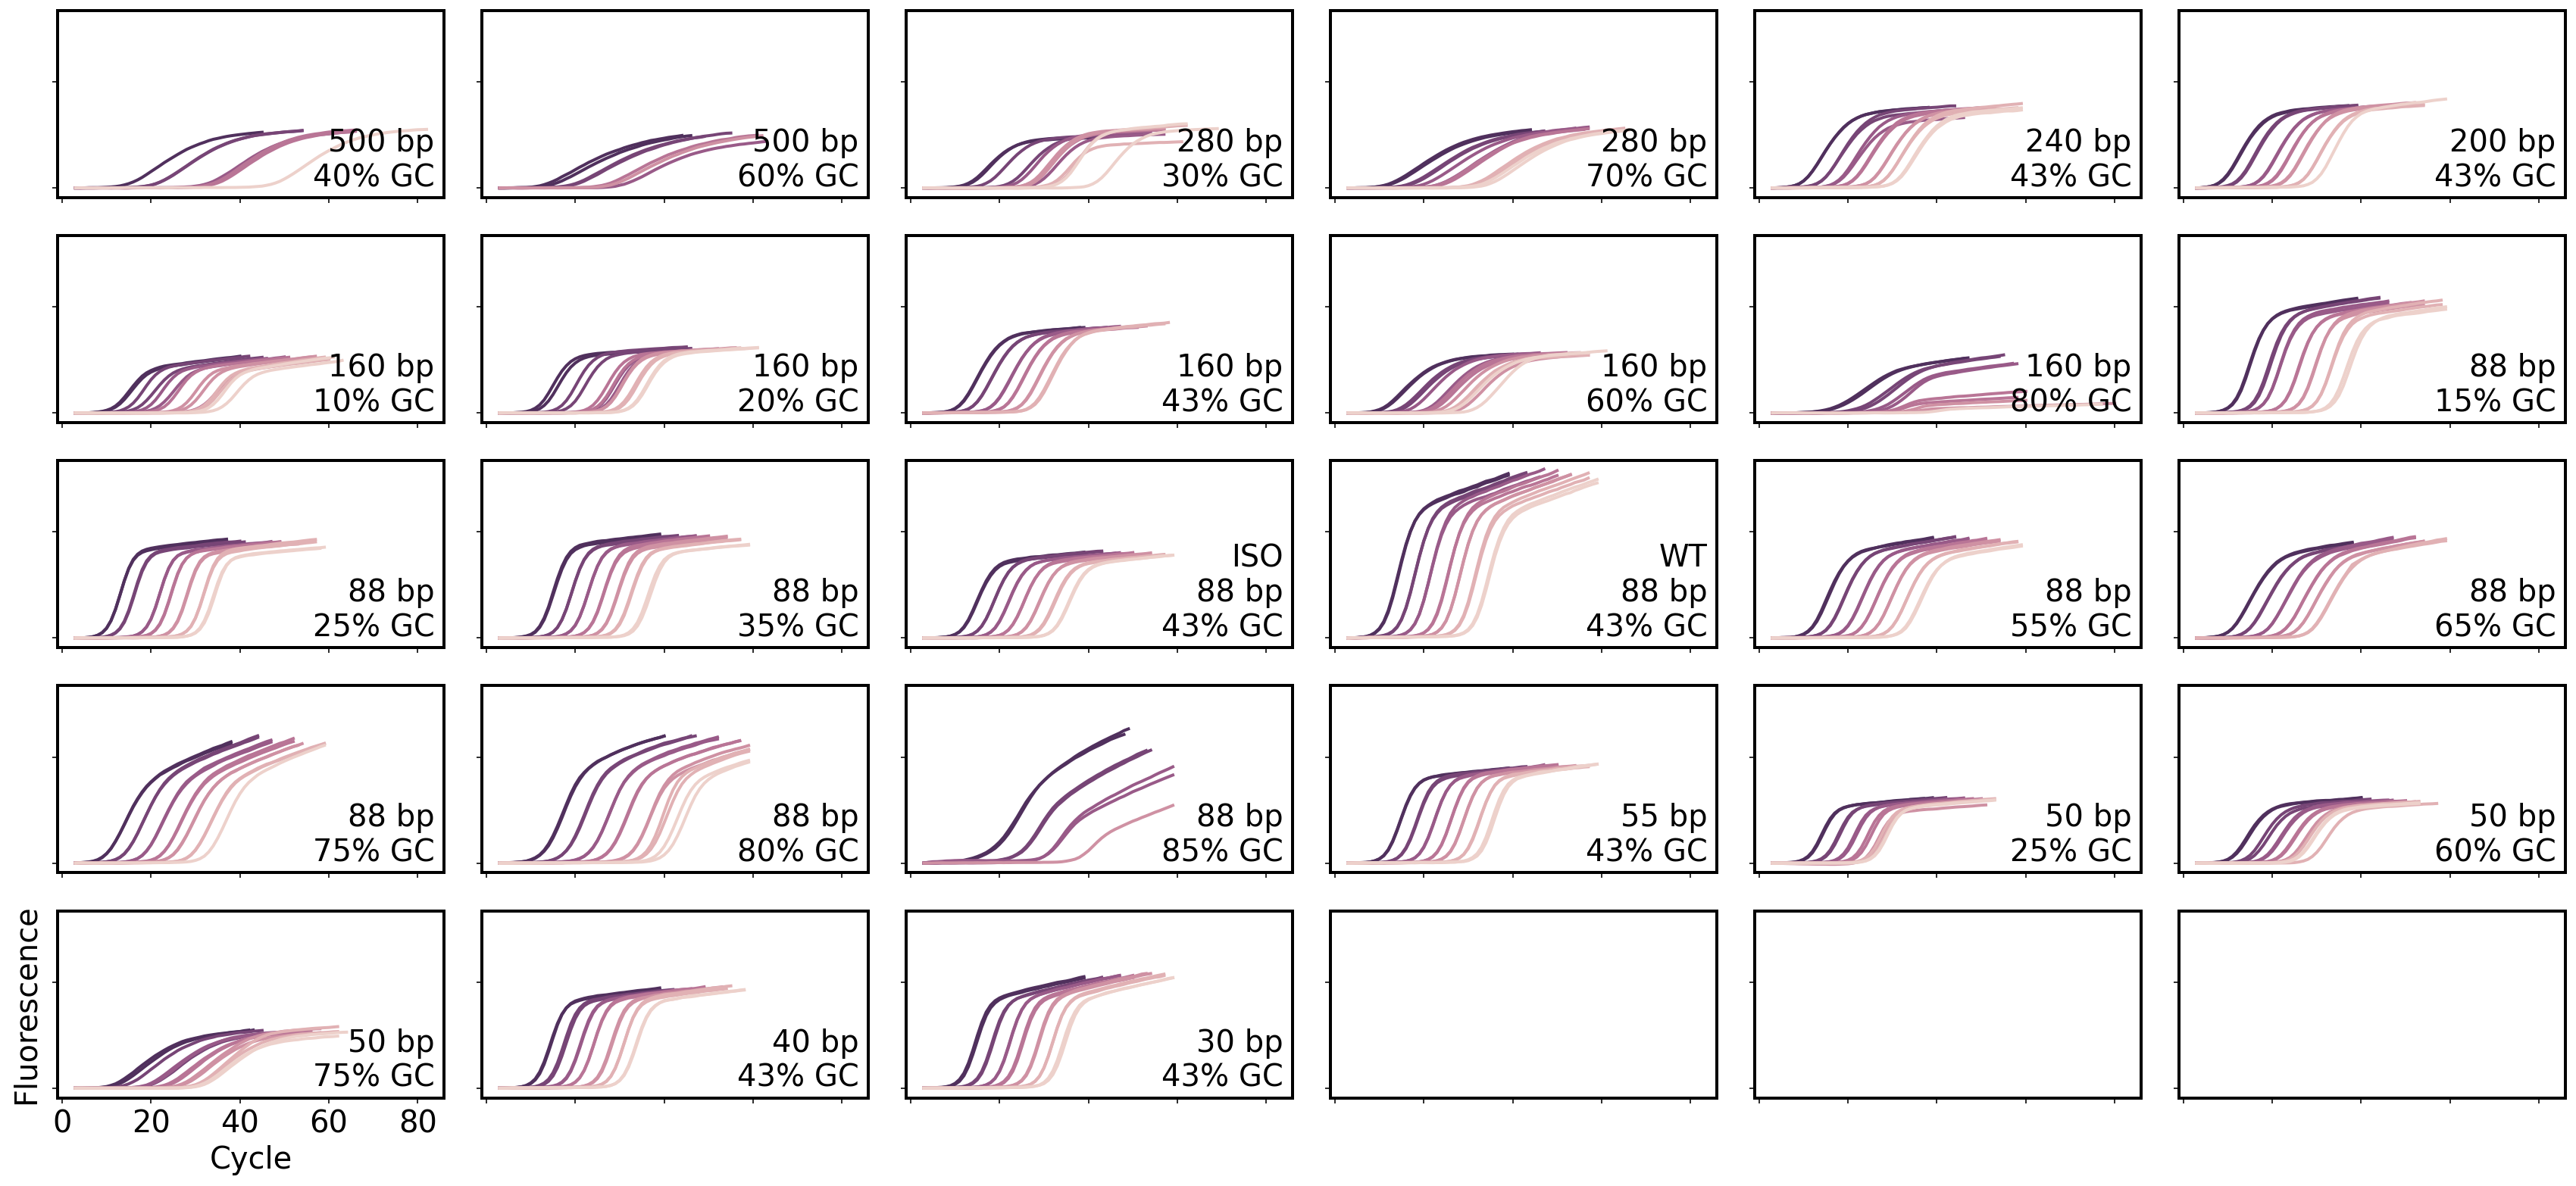

In [10]:
fig, axs = plt.subplots(5,6, figsize = (16*1.5,7.5*1.5), sharex=True, sharey=True)

for ax,tar in zip(axs.flat,t_list[:-2]):
    for row in rxns.query('~outlier & Tar==@tar').itertuples():
        if not row.outlier:
            ax.plot(row.Cycle, row.Rn-row.Rn[0], '-', color=row.color)
    parts = tar.split('_')
    bp = parts[0][2:]+' bp'
    gc = parts[1][2:]+'% GC'
    name = parts[2] if len(parts)>2 else ''
    title = f'{name}\n{bp}\n{gc}'
    ax.text(.975,.025,title,
            horizontalalignment='right',
            verticalalignment='bottom',
            transform=ax.transAxes)

#ax_NTC = axs.flat[len(t_list[:-2])]
#for row in rxns[rxns.Tar=='NTC'].itertuples():
#    ax_NTC.plot(row.Cycle, row.Rn-row.Rn[0], '-', color='k', alpha=0.25)

plt.setp(axs.flat, yticklabels = '', xticks = [0,20,40,60,80])

plt.setp(axs.flat[-6],
         xlabel = 'Cycle',
         ylabel = 'Fluorescence',
        );

for ax in axs.flat[-5:]:
    plt.setp(ax.get_xticklabels(), visible=False)
    
plt.setp(axs.flat[-6],
     xlabel = 'Cycle',
     ylabel = 'Fluorescence',
    );

plt.tight_layout()

if savefigs: savemyfig(plt.gcf(), 'TMCC1 Curves - grid - sharey')

# Standardize inputs and output parameters

In [11]:
param_ests = pQS.get_param_estimates(rxns)
valid_params = param_ests[(param_ests['ρ']>0) & (rxns.Tar!='NTC') & ~rxns.outlier]

In [12]:
skip = lambda x: x

transforms = {
    'r':[skip,skip], 
    'ρ':[sp.special.logit,sp.special.expit], 
    'τ':[np.log,np.exp], 
    'τ_':[np.log,np.exp], 
    'K':[np.log,np.exp], 
    'm':[np.log,np.exp], 
    'offset':[skip,skip], 
    'Q':[skip,skip], 
    'BP':[np.log,np.exp], 
    'GC':[sp.special.logit,sp.special.expit]
}

pymc_transforms = {
    'r':[skip,skip], 
    'ρ':[pm.math.logit,pm.math.invlogit], 
    'τ':[pm.math.log,pm.math.exp], 
    'τ_':[pm.math.log,pm.math.exp], 
    'K':[pm.math.log,pm.math.exp], 
    'm':[pm.math.log,pm.math.exp], 
    'offset':[skip,skip], 
    'Q':[skip,skip], 
    'BP':[pm.math.log,pm.math.exp], 
    'GC':[pm.math.logit,pm.math.invlogit]
}

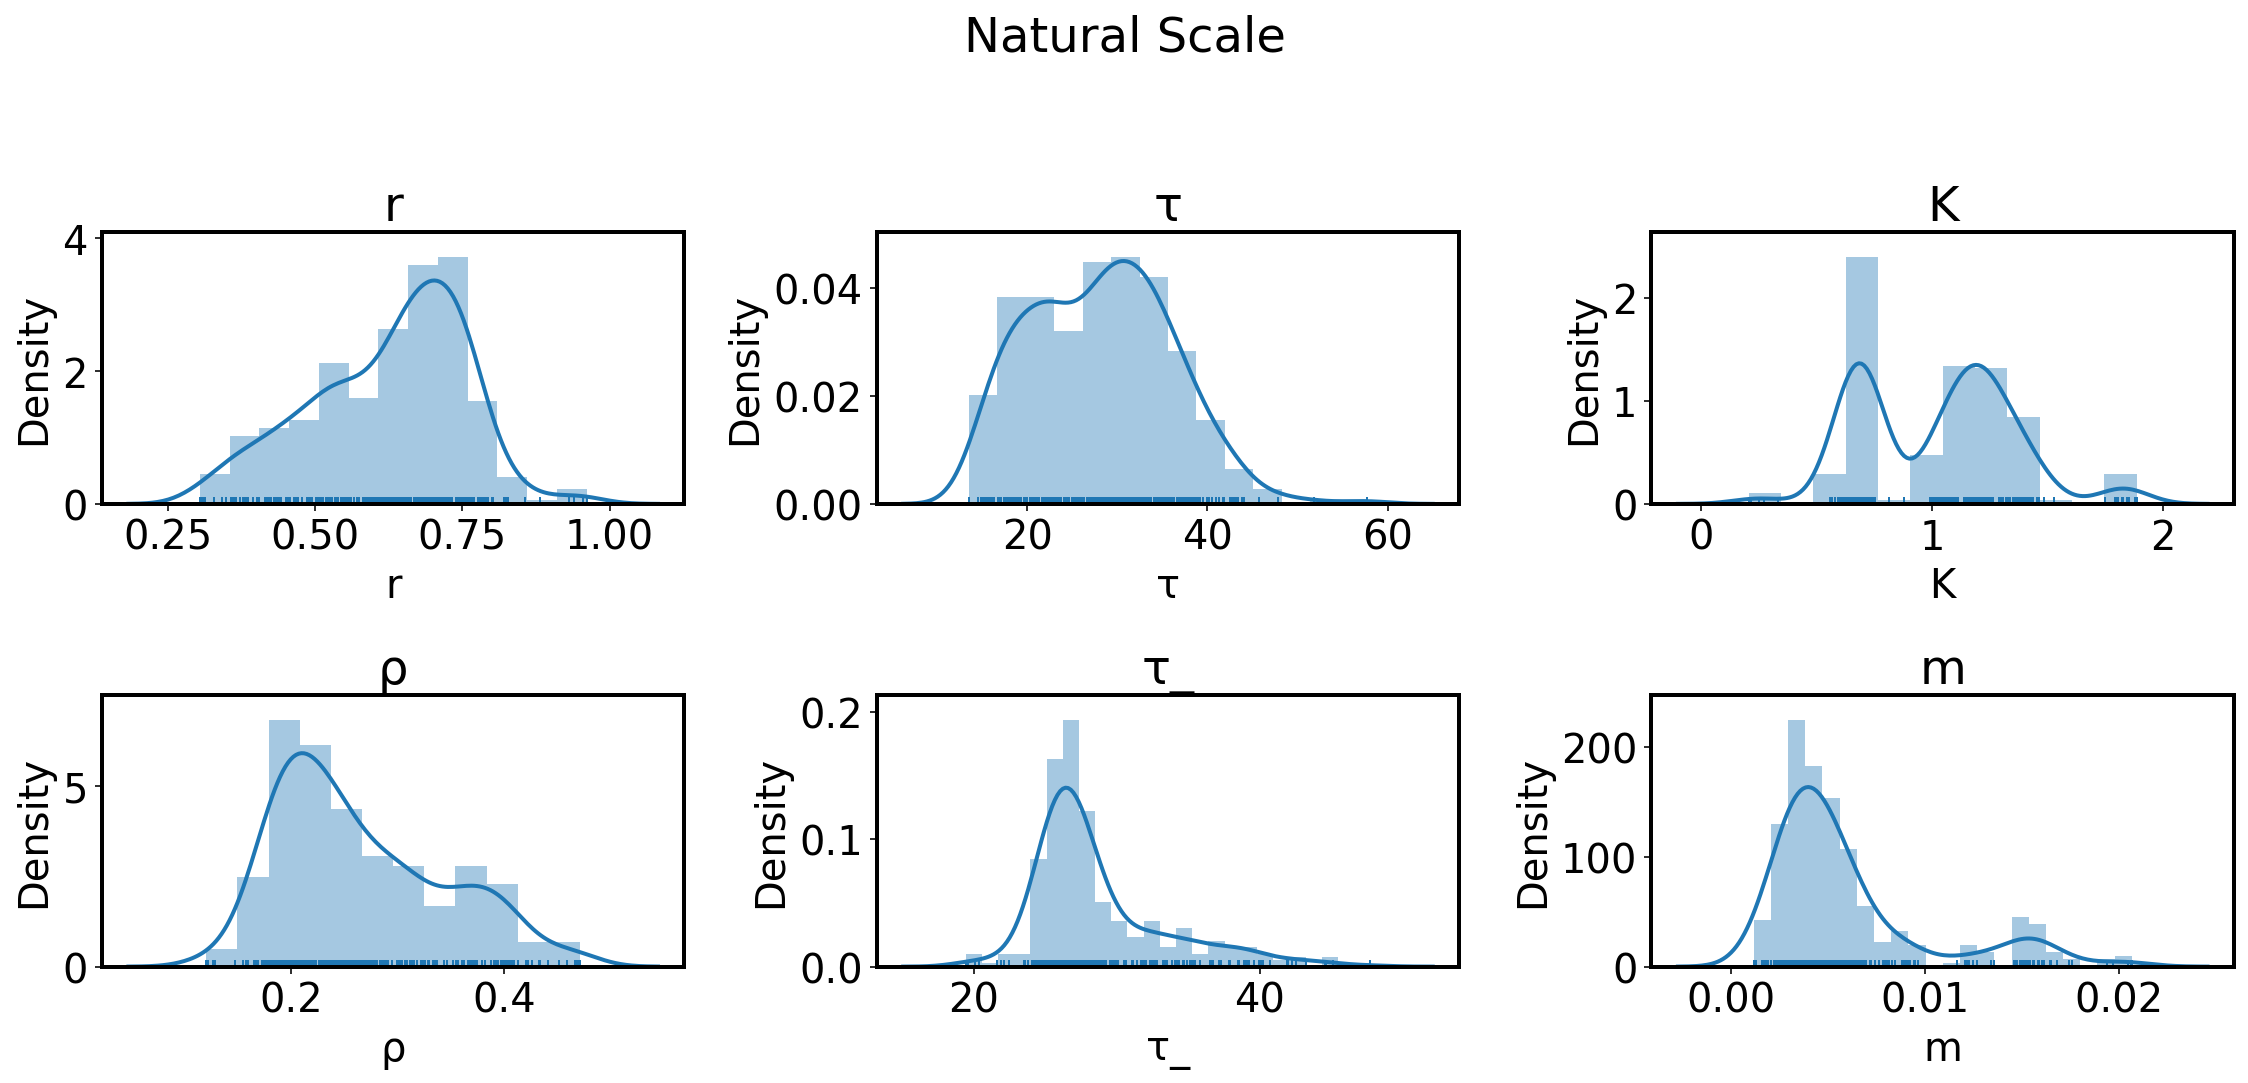

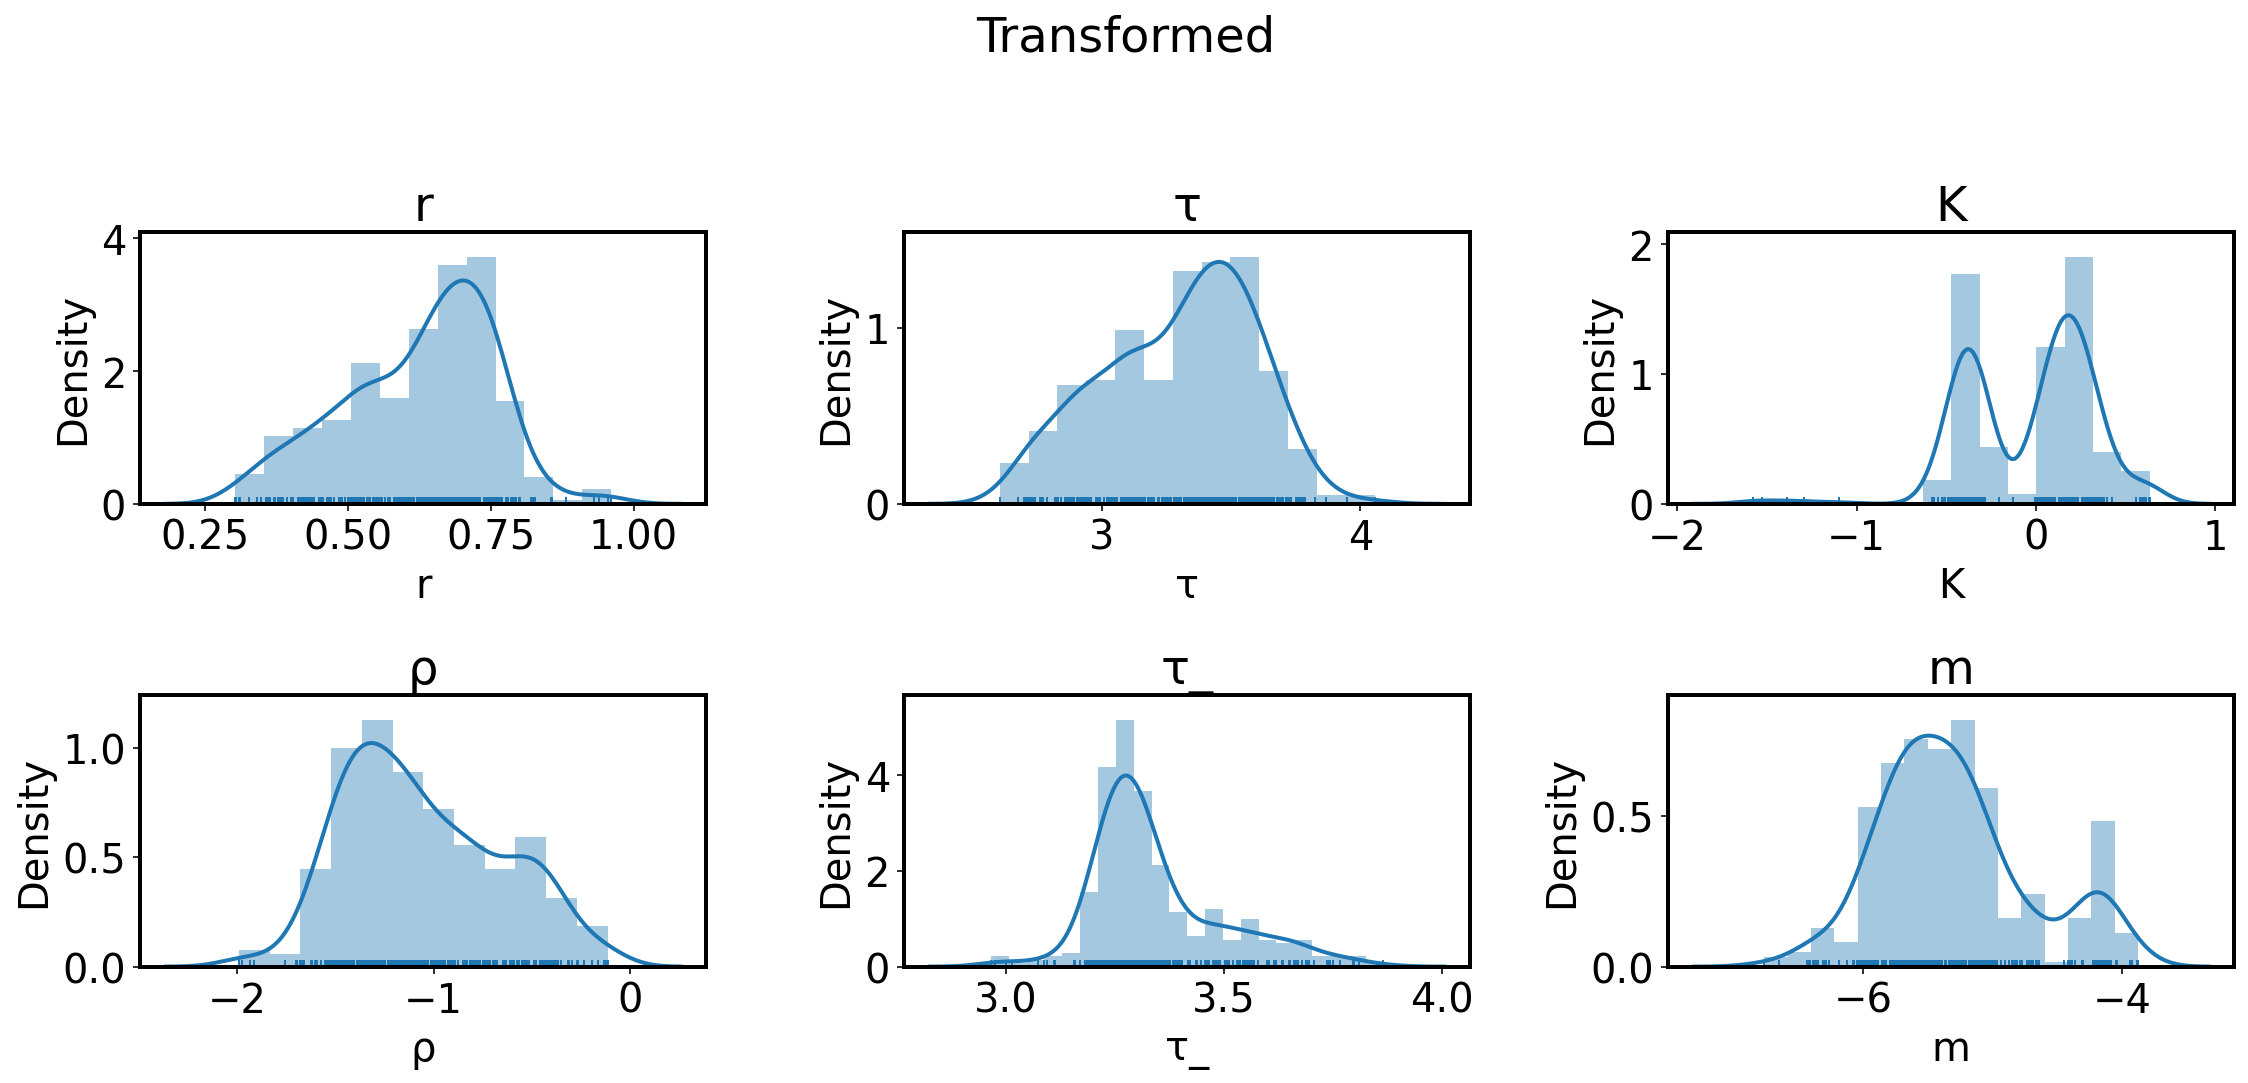

In [13]:
fig, axs = plt.subplots(2,3, figsize = (16,8))
for i,name in enumerate(['r','ρ','τ','τ_','K','m']):
    sns.distplot(valid_params[name], rug=True, ax=axs.T.flat[i])
    axs.T.flat[i].set_title(name)
    
plt.suptitle('Natural Scale')
plt.tight_layout(rect=[0, 0.03, 1, 0.95])

fig, axs = plt.subplots(2,3, figsize = (16,8))
for i,(name) in enumerate(['r','ρ','τ','τ_','K','m']):
    sns.distplot(transforms[name][0](valid_params[name]), rug=True, ax=axs.T.flat[i])
    axs.T.flat[i].set_title(name)
    
plt.suptitle('Transformed')
plt.tight_layout(rect=[0, 0.03, 1, 0.95])

In [14]:
lg_Q = rxns.Tar_Q
Q = [2,3,4,5,6,7,8]

names = ['ρ','τ','K','m','offset','Q','BP','GC']
params = ['ρ','τ_','K','m','bkg_α']

stdzr = {name: {'μ':[], 'σ':[]} for name in names}

for (param, name) in zip(params, names):
    stdzr[name]['μ'] = np.mean(transforms[name][0](valid_params[param]))
    stdzr[name]['σ'] = np.std(transforms[name][0](valid_params[param]))
    
stdzr['BP']['μ'] = np.log(88)
stdzr['BP']['σ'] = 0.75
stdzr['GC']['μ'] = sp.special.logit(0.43)
stdzr['GC']['σ'] = 1
stdzr['Q']['μ'] = 5
stdzr['Q']['σ'] = 2

In [23]:
standardizers = pQS.build_standardizers(stdzr, transforms, pymc_transforms, 88, 43)

stdz, unstdz, pm_stdz, pm_unstdz, get_BP, get_GC = standardizers
    
with open(rslt_pth / 'JG047 Standardizers.pkl','wb') as buff:
    pickle.dump({'stdzr':stdzr},buff)

# Load in GBP6 Data

In [16]:
filename = 'JG039A - GBP6 Gen1 Solo and Competitive.xlsx'
gbp6_imp = pQS.importQuantStudio(data_pth, filename)

aliases =   {'WT' : 'BP74_GC53_WT', 'ISO' : 'BP74_GC53_ISO'}

gbp6_rxns = pQS.formatSNXimport(gbp6_imp).assign(Batch=1).query('WellPosition < "J1"').replace(aliases)
gbp6_rxns = pQS.apply_reaction_bounds(gbp6_rxns)
gbp6_rxns = pQS.trim_reactions(gbp6_rxns)

outliers = rxns.outlier

gbp6_targets = gbp6_rxns.Tar.unique()
n_t = len(gbp6_targets)
gbp6_rxns.to_pickle(data_pth / 'GBP6_rxns.pkl',protocol=4)

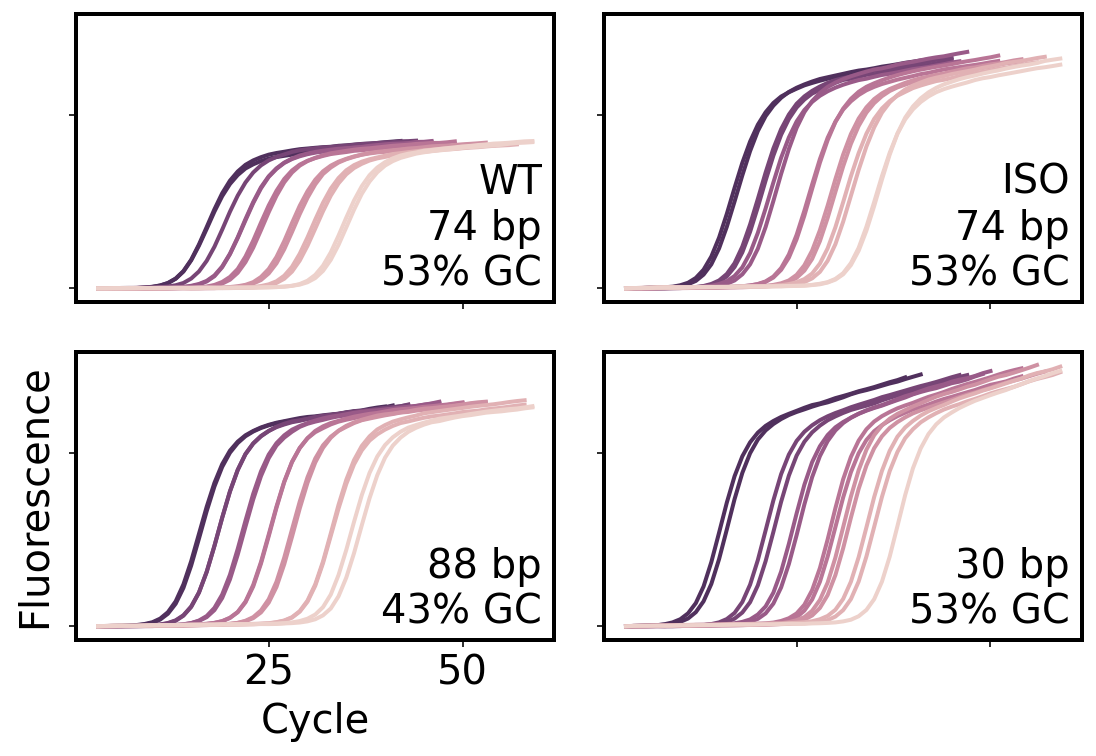

In [17]:
fig, axs = plt.subplots(2,2, figsize = (16*0.5,7.5*0.75), sharex=True, sharey=True)

for ax,tar in zip(axs.flat,gbp6_targets):
    for row in gbp6_rxns.query('~outlier & Tar==@tar').itertuples():
        if not row.outlier:
            ax.plot(row.Cycle, row.Rn-row.Rn[0], '-', color=row.color)
    parts = tar.split('_')
    bp = parts[0][2:]+' bp'
    gc = parts[1][2:]+'% GC'
    name = parts[2] if len(parts)>2 else ''
    title = f'{name}\n{bp}\n{gc}'
    ax.text(.975,.025,title,
            horizontalalignment='right',
            verticalalignment='bottom',
            transform=ax.transAxes)

plt.setp(axs.flat, yticklabels = '')#, xticks = [0,20,40,60,80])

plt.setp(axs[-1,0],
         xlabel = 'Cycle',
         ylabel = 'Fluorescence',
        );

for ax in axs[-1,1:]:
    plt.setp(ax.get_xticklabels(), visible=False)
    
plt.setp(axs[-1,0],
     xlabel = 'Cycle',
     ylabel = 'Fluorescence',
    );

plt.tight_layout()

if savefigs: savemyfig(plt.gcf(), 'GBP6 Curves')

# Load in ARG1 Data

In [18]:
filename = 'JG039B - ARG1 Gen1 Solo and Competitive.xlsx'
arg1_imp = pQS.importQuantStudio(data_pth, filename)

aliases = {'WT' : 'BP108_GC48_WT', 'ISO' : 'BP108_GC48_ISO'}

arg1_rxns = pQS.formatSNXimport(arg1_imp).assign(Batch=1).query('WellPosition < "J1"').replace(aliases)
arg1_rxns = pQS.apply_reaction_bounds(arg1_rxns)
arg1_rxns = pQS.trim_reactions(arg1_rxns)

outliers = arg1_rxns.outlier

arg1_targets = arg1_rxns.Tar.unique()
n_t = len(arg1_targets)
arg1_rxns.to_pickle(data_pth / 'ARG1_rxns.pkl',protocol=4)

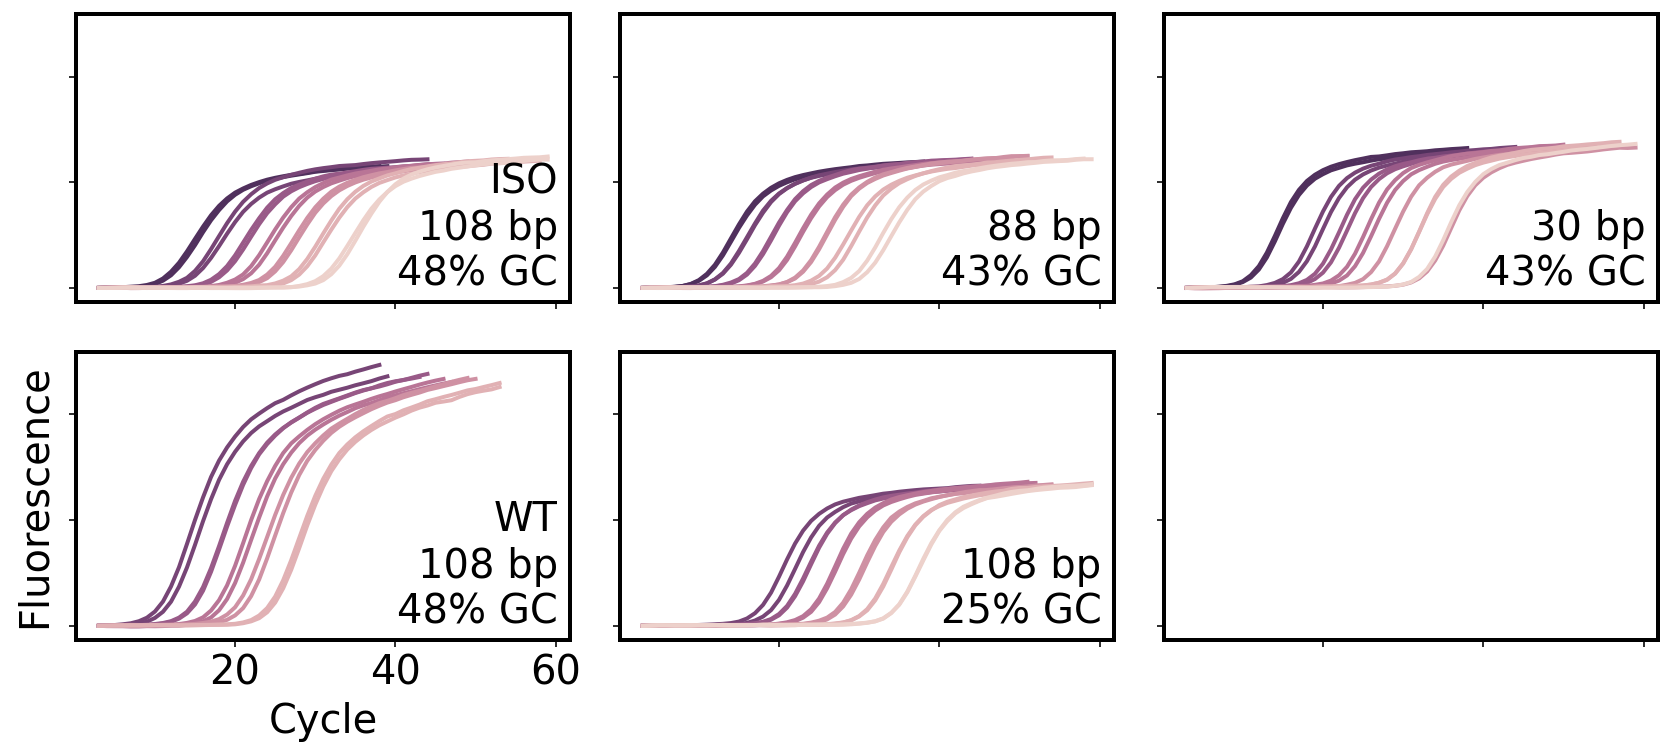

In [19]:
fig, axs = plt.subplots(2,3, figsize = (16*0.75,7.5*0.75), sharex=True, sharey=True)

for ax,tar in zip(axs.flat,arg1_targets):
    for row in arg1_rxns.query('~outlier & Tar==@tar').itertuples():
        if not row.outlier:
            ax.plot(row.Cycle, row.Rn-row.Rn[0], '-', color=row.color)
    parts = tar.split('_')
    bp = parts[0][2:]+' bp'
    gc = parts[1][2:]+'% GC'
    name = parts[2] if len(parts)>2 else ''
    title = f'{name}\n{bp}\n{gc}'
    ax.text(.975,.025,title,
            horizontalalignment='right',
            verticalalignment='bottom',
            transform=ax.transAxes)

plt.setp(axs.flat, yticklabels = '')#, xticks = [0,20,40,60,80])

plt.setp(axs[-1,0],
         xlabel = 'Cycle',
         ylabel = 'Fluorescence',
        );

for ax in axs[-1,1:]:
    plt.setp(ax.get_xticklabels(), visible=False)
    
plt.setp(axs[-1,0],
     xlabel = 'Cycle',
     ylabel = 'Fluorescence',
    );

plt.tight_layout()

if savefigs: savemyfig(plt.gcf(), 'ARG1 Curves')

# Sequence-level model

In [25]:
def make_GLM(df):

    data = df.reset_index()
    
    with pm.Model() as model:
    
        c = pm.Data('c',np.hstack(data.Cycle))
        F_obs = pm.Data('F_obs',np.hstack(data.Rn))
        rxn = pm.Data('rxn',np.hstack(data.apply(lambda row: np.full(row.Rn.shape,row.name), axis=1)))
        n_rxns = len(data)
    
        lg_Q = pm.Data('lg_Q',data.Tar_Q.values)
        lg_Q_z = pm_stdz(lg_Q,'Q')

        ρ_lgt_α = pm.Normal('ρ_lgt_α', mu=0, sigma=1)
        ρ_lgt_β = pm.Normal('ρ_lgt_β', mu=0, sigma=1)
        ρ_lgt_µ = pm.Deterministic('ρ_lgt_µ', ρ_lgt_α + ρ_lgt_β*lg_Q_z)
        ρ_lgt_σ = pm.Exponential('ρ_lgt_σ', lam=1)
        ρ_lgt_z, _ = pmu.nc_Normal('ρ_lgt_z', mu=ρ_lgt_μ, sigma=ρ_lgt_σ, shape=n_rxns)
        ρ = pm.Deterministic('ρ', pm_unstdz(ρ_lgt_z,'ρ'))

        τ_lg_α = pm.Normal('τ_lg_α', mu=0, sigma=1)
        #τ_lg_β = pm.Normal('τ_lg_β', mu=0, sigma=1)
        τ_lg_µ = pm.Deterministic('τ_lg_µ', τ_lg_α)# + τ_lg_β*lg_Q_z)
        τ_lg_σ = pm.Exponential('τ_lg_σ', lam=1)
        τ_lg_z, _ = pmu.nc_Normal('τ_lg_z', mu=τ_lg_µ, sigma=τ_lg_σ, shape=n_rxns)
        τ = pm.Deterministic('τ', pm_unstdz(τ_lg_z,'τ',lg_Q))

        K_lg_α = pm.Normal('K_lg_α', mu=0, sigma=1)
        #K_lg_β = pm.Normal('K_lg_β', mu=0, sigma=1)

        m_lg_α = pm.Normal('m_lg_α', mu=0, sigma=1)
        #m_lg_β = pm.Normal('m_lg_β', mu=0, sigma=1)
        
        offset_α = pm.Normal('offset_α', mu=0,sigma=1)

        joint_μs = tt.stack([offset_α,K_lg_α,m_lg_α])
        
        chol_cov = pm.LKJCholeskyCov('chol_cov', n=3, eta=2,
                                     sd_dist=pm.Exponential.dist(lam=1, shape=3),
                                     compute_corr=True)

        L = pm.Deterministic('L',chol_cov[0])
        Σ = pm.Deterministic('Σ',chol_cov[1])
        Mv_σs = pm.Deterministic('Mv_σs',chol_cov[2])

        
        joint_vars_nc = pm.Normal('joint_vars_nc', mu=0, sigma=1, shape=(n_rxns,3))
        joint_vars = pm.Deterministic('joint_vars', joint_μs + tt.dot(L, joint_vars_nc.T).T)
                       
        K_lg_z = pm.Deterministic('K_lg_z', joint_vars[:,1])# + K_lg_β*lg_Q_z)
        m_lg_z = pm.Deterministic('m_lg_z', joint_vars[:,2])# + m_lg_β*lg_Q_z)
        K = pm.Deterministic('K', pm_unstdz(K_lg_z,'K'))
        m = pm.Deterministic('m', pm_unstdz(m_lg_z,'m'))


        F0_lg = pm.Deterministic('F0_lg', -τ**(1-ρ)/np.log(10))
        F0 = pm.Deterministic('F0', 10**F0_lg)

        r = pm.Deterministic('r', τ**(-ρ)/np.log(2))
        r_α = pm.Deterministic('r_α', pm_unstdz(τ_lg_α,'τ',lg_Q)**(-pm_unstdz(ρ_lgt_α,'ρ'))/np.log(2))
        r_µ = pm.Deterministic('r_µ', pm_unstdz(τ_lg_μ,'τ',lg_Q)**(-pm_unstdz(ρ_lgt_μ,'ρ'))/np.log(2))

        noise, _ = pmu.sc_Exponential('noise', mu=0.01, shape=n_rxns)

        # Generate predicted signal for each reaction
        # The "background" reactions have no amplification parameters, so set them to 1 for those reactions
        
        _τ = τ[rxn]
        _F0 = F0[rxn]
        _r = r[rxn]*np.log(2)
        _K = K[rxn]
        _m = m[rxn]
        
        offset_z = joint_vars[:,0][rxn]
        offset = unstdz(offset_z,'offset')
        
        F =  _K / (1 + (_K - _F0) / _F0 * pm.math.exp(-_r * c))
        signal = F*(1 + F / _K * _m * (c-_τ)) + offset

        # Likelihood of observations
        F_lik = pm.Normal('F_lik', mu=signal, sigma=noise[rxn], observed=F_obs)
                 
    return model

## Compile a model for each sequence

In [44]:
models = dict()
all_rxns = [tmcc1_rxns,arg1_rxns,gbp6_rxns]
all_targets = [tmcc1_targets,arg1_targets,gbp6_targets]
genes = ['TMCC1', 'ARG1', 'GBP6']
for gene,targets,rxns in tqdm(zip(genes, all_targets, all_rxns)):
    for tar in tqdm(targets):
        models[tar] = make_GLM(rxns[(rxns.Tar==tar) & ~rxns.outlier])
        with open(rslt_pth / gene / str(tar+'_model.pkl'),'wb') as buff:
            pickle.dump(models[tar], buff)

In [42]:
np.cumsum(list(map(len,all_targets)))

array([27, 32, 36])

In [45]:
len(tmcc1_targets)

27

In [46]:
len(all_targets)

3

In [47]:
TMCC1_targets = [
    'BP88_GC43_ISO', 'BP88_GC43_WT', 'BP30_GC43', 'BP40_GC43',
    'BP55_GC43', 'BP160_GC43', 'BP200_GC43', 'BP240_GC43', 'BP88_GC15',
    'BP88_GC25', 'BP88_GC35', 'BP88_GC55', 'BP88_GC65', 'BP88_GC75',
    'BP88_GC80', 'BP88_GC85', 'BP160_GC10', 'BP160_GC20', 'BP160_GC60',
    'BP160_GC80', 'BP280_GC70', 'BP280_GC30', 'BP500_GC40',
    'BP50_GC25', 'BP50_GC60', 'BP50_GC75', 'BP500_GC60'
]

ARG1_targets = [
    'BP108_GC48_ISO', 'BP88_GC43', 'BP30_GC43', 'BP108_GC48_WT', 'BP108_GC25'
]

GBP6_targets = [
    'BP74_GC53_WT', 'BP74_GC53_ISO', 'BP88_GC43', 'BP30_GC53'
]

lens = np.cumsum(list(map(len,[TMCC1_targets,ARG1_targets,GBP6_targets])))

In [48]:
lens

array([27, 32, 36])

In [49]:
i in range(lens[0],lens[1]) for i in range(27)

False